# Рекомендательная система на основе рейтинга товара

## Библиотеки

In [83]:
import pandas as pd
import ipyplot

## Загрузка данных

In [69]:
transactions_train = pd.read_csv('./data_prepared/transactions_train.csv', date_parser='t_dat', dtype={'article_id': str})
articles = pd.read_csv('./data_prepared/articles.csv', dtype={'article_id': str})
customers = pd.read_csv('./data_prepared/customers.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

## Константы

In [12]:
count_articles = 12

## Глобальный рейтинг

Возьмем `count_articles` самых популярных товаров и проставим для каждого пользователя

In [13]:
articles = articles.sort_values(by='rating', ascending=False)

top_articles = articles[:count_articles]['article_id']
top_articles_in_str = ' '.join(top_articles)

In [14]:
top_articles_in_str

'0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001'

In [15]:
sample_submission.iloc[0]['prediction']

'0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001'

### Вывод

sample_submission идеально соответсвует результату рекомендательной системе на основе простому рейтингу.

А вот результат этого решения на Kaggle:

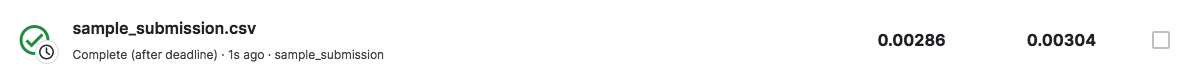

## Рейтинг по каждой возрастной группе

In [16]:
def get_top_articles(df: pd.DataFrame, by: str, value: str, count: int):
    return df[df[by] == value].sort_values(by='rating', ascending=False)[:count]['article_id']

In [24]:
def articles_to_str(series: pd.Series):
    return ' '.join(series.astype(str))

In [38]:
age_groups = customers['age_group'].unique().tolist()
transactions_train = transactions_train.merge(customers[['customer_id', 'age_group']], on='customer_id', how='left')
transactions_train = transactions_train.merge(articles[['article_id', 'rating']], on='article_id', how='left')

In [61]:
group_and_top_article = transactions_train.groupby('age_group')[['article_id', 'rating']]
group_and_top_article = group_and_top_article.apply(lambda x: x.sort_values(by='rating', ascending=False)[:count_articles])

In [63]:
top_articles = dict()

for group in age_groups:
    top_articles[group] = ' '.join(group_and_top_article.loc[group]['article_id'])

### Предсказывание

In [74]:
sample_submission['prediction'] = sample_submission.merge(customers[['customer_id', 'age_group']], on='customer_id', how='left')['age_group']
sample_submission['prediction'] = sample_submission['prediction'].map(top_articles)

In [78]:
sample_submission.to_csv('./prediction/rating_base.csv', index=False)

In [82]:
sample_submission['prediction'].value_counts()

0706016001 0706016001 0706016001 0706016001 0706016001 0706016001 0706016001 0706016001 0706016001 0706016001 0706016001 0706016001    1371879
0706016001 0372860001 0610776002 0610776002 0759871002 0759871002 0759871002 0372860002 0610776001 0156231001 0351484002 0399256001        101
Name: prediction, dtype: int64

### Вывод

Топ товаров для каждой возрастной категории индентичен, кроме группы `LONG_LIVE (90 - 100 лет)`

Результат еще стал хуже

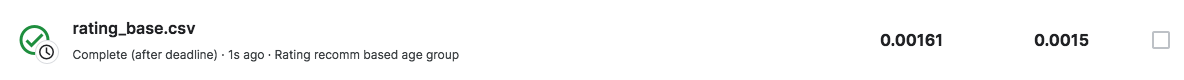

Посмотрим, какие товары мы порекомендовали долгожителям

In [85]:
top_articles_for_long_live = top_articles['LONG_LIVE'].split(' ')

path_to_top_articles = [f'./data/images/{article[:3]}/{article}.jpg' for article in top_articles_for_long_live]
labels = articles.set_index('article_id').loc[top_articles_for_long_live]['section_name'].to_list()

In [86]:
ipyplot.plot_images(path_to_top_articles, labels, max_images=count_articles, img_width=150, show_url=False)